In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import joblib
import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
features, labels = [], []
training_files = ["../dataset/individual/tcp_dataset_individual_attack_3detik.csv",
                  "../dataset/individual/tcp_dataset_individual_normal_3detik_1.csv",
                  "../dataset/individual/tcp_dataset_individual_normal_3detik_2.csv"]

In [3]:
def scrape_data():
    global training_files
    global features
    global labels
    
    for fname in training_files:
        meal = open(fname, "rt")
        for line in meal:
            data_list = line.rsplit(",")
            if(len(data_list) != 14):
                print("error data")
            else:
                data_list[(len(data_list)-1)]=int(data_list[(len(data_list)-1)].replace('\n', ''))
                features.append(data_list[:(len(data_list)-1)])
                labels.append(data_list[(len(data_list)-1)])
        meal.close()
    
    data_counter = Counter(labels)
    print(data_counter)
    
    over = SMOTE()
    under = RandomUnderSampler()
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    features, labels = pipeline.fit_resample(features, labels)
    
    data_counter = Counter(labels)
    print(data_counter)
    
    scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
    scalar.fit(features)
    features = scalar.transform(features)
    
    features = np.array(features).astype(np.float64)
    features = features.tolist()
    
    print(f"Size of feature dataset : {len(features)}")
    print(f"Size of feature dataset : {len(labels)}")
    print("Features first and last entries:\n\t", end = "")
    print(features[:1] + features[(len(features)-1):])
    print("Labels first and last entries:\n\t", end = "")
    print(labels[:1] + labels[(len(features)-1):])
    
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.20, stratify=labels, random_state = 0)
    
    return np.asarray(features_train), np.asarray(labels_train), np.asarray(features_test), np.asarray(labels_test)

In [4]:
def generate_model(shape):
    model = Sequential()

    model.add(Dense(256, input_dim=shape, kernel_initializer='uniform', activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())

    return model

In [5]:
data_train, label_train, data_eval, label_eval = scrape_data()

Counter({0: 250, 1: 161})
Counter({0: 250, 1: 250})
Size of feature dataset : 500
Size of feature dataset : 500
Features first and last entries:
	[[-2.3464594435212067, -0.629119114288364, -1.0788031275306045, -0.008415225029301473, 0.5417995290996331, 0.8060258210814472, 0.0, 1.0638903188996094, 0.6013156713410271, -0.2385023150519984, 0.0, 0.5677972135118733, -1.0685450137625268], [0.532976907130693, 1.6636175185304212, -1.075257830082479, -0.7249270078245899, -0.6232864737846427, -0.9101750773421672, 0.0, -0.8884324663745962, -0.9302035155477887, 0.44578410224094633, 0.0, -0.7323478390603453, -0.062044847163576784]]
Labels first and last entries:
	[0, 1]


C:\Users\H P VICTUS\anaconda3\lib\site-packages\sklearn\utils\validation.py:964: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(


In [6]:
model = generate_model(len(data_train[0]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3584      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
checkpoint = ModelCheckpoint("dnnModel.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')

In [10]:
history = model.fit(data_train, label_train, validation_split=0.2, epochs=100, verbose = 1, callbacks=[checkpoint,early])

Epoch 1/100
 1/10 [==>...........................] - ETA: 11s - loss: 0.7156 - accuracy: 0.5000
Epoch 00001: val_loss improved from inf to 0.54128, saving model to dnnModel.h5
10/10 [==============================] - 1s 18ms/step - loss: 0.6414 - accuracy: 0.7312 - val_loss: 0.5413 - val_accuracy: 0.9750
Epoch 2/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.5466 - accuracy: 0.9062
Epoch 00002: val_loss improved from 0.54128 to 0.26530, saving model to dnnModel.h5
10/10 [==============================] - 0s 9ms/step - loss: 0.4376 - accuracy: 0.9563 - val_loss: 0.2653 - val_accuracy: 0.9750
Epoch 3/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.2890 - accuracy: 1.0000
Epoch 00003: val_loss improved from 0.26530 to 0.10646, saving model to dnnModel.h5
10/10 [==============================] - 0s 7ms/step - loss: 0.1960 - accuracy: 0.9844 - val_loss: 0.1065 - val_accuracy: 0.9750
Epoch 4/100
 1/10 [==>...........................] - ETA: 0s - loss: 0.0743 - 

 1/10 [==>...........................] - ETA: 0s - loss: 6.6842e-05 - accuracy: 1.0000
Epoch 00030: val_loss did not improve from 0.10646
10/10 [==============================] - 0s 5ms/step - loss: 1.5301e-04 - accuracy: 1.0000 - val_loss: 0.4210 - val_accuracy: 0.9750
Epoch 31/100
 1/10 [==>...........................] - ETA: 0s - loss: 1.6533e-05 - accuracy: 1.0000
Epoch 00031: val_loss did not improve from 0.10646
10/10 [==============================] - 0s 5ms/step - loss: 4.0848e-04 - accuracy: 1.0000 - val_loss: 0.4235 - val_accuracy: 0.9750
Epoch 32/100
 1/10 [==>...........................] - ETA: 0s - loss: 6.9456e-06 - accuracy: 1.0000
Epoch 00032: val_loss did not improve from 0.10646
10/10 [==============================] - 0s 6ms/step - loss: 2.1588e-04 - accuracy: 1.0000 - val_loss: 0.4266 - val_accuracy: 0.9750
Epoch 33/100
 1/10 [==>...........................] - ETA: 0s - loss: 3.3429e-05 - accuracy: 1.0000
Epoch 00033: val_loss did not improve from 0.10646
10/10 [===

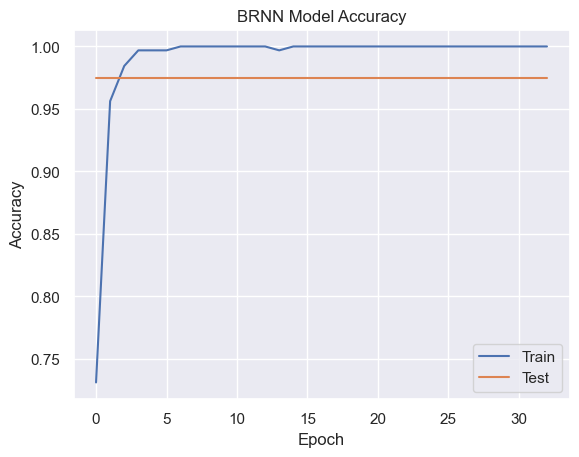

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
# plt.savefig('BRNN 200 Model Accuracy.png')
plt.show()

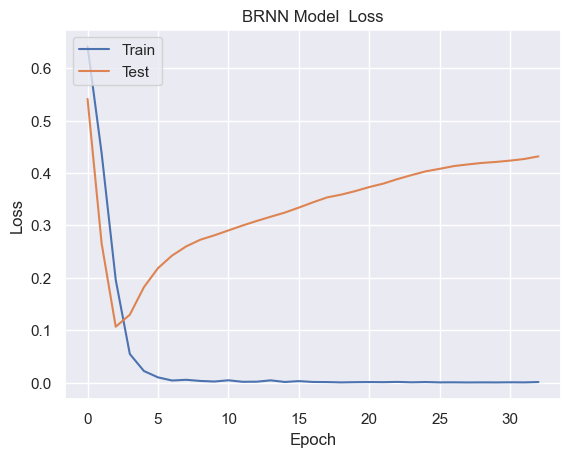

In [12]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# plt.savefig('BRNN 200 Model Loss.png')
plt.show()

In [13]:
predict = model.predict(data_eval, verbose=1)

4/4 [==============================] - 0s 2ms/step


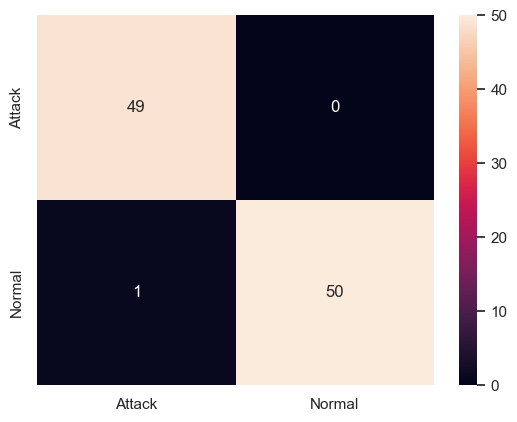

In [14]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = label_eval.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [15]:
scores = model.evaluate(data_eval, label_eval)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

4/4 [==============================] - 0s 2ms/step - loss: 0.0666 - accuracy: 0.9900
accuracy: 99.00%


In [16]:
print(classification_report(Y_testn,predictn))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [17]:
lr_auc = roc_auc_score(Y_testn, predictn)
print('SVM: ROC AUC=%.3f' % (lr_auc))

SVM: ROC AUC=0.990


In [18]:
time_start = time.perf_counter()
predict = model.predict(data_eval[:1], verbose=1)
print(f"Time elapse for prediction : {time.perf_counter() - time_start}")
print(predict)

1/1 [==============================] - 0s 14ms/step
Time elapse for prediction : 0.041448499999999555
[[0.9999995]]
